In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torchinfo
from tqdm import tqdm

In [4]:
# data_dir = "/Users/trevoryu/Code/syde_599/data/norm_fog_data/"
data_dir = "/root/trevor/syde599/norm_fog_data/"

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

In [6]:
data = np.loadtxt(data_files[0], delimiter=",", skiprows=1)
data.shape

(37501, 32)

# Load the data

In [7]:
WINDOW_SIZE = 512

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]

    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = y.size // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    x = x[:end, :]  # (n_samples, d)
    y = y[:end]

    # Reshape into (n_windows, window_size, d)
    x = x.reshape(n_windows, WINDOW_SIZE, -1)
    y = y.reshape(n_windows, WINDOW_SIZE)
    
    if patient_num in ('001', '005', '007'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)

In [8]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

# Build dataset and dataloader

In [9]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        labels = self._reduce_labels(labels)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


In [10]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)


BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Define model

In [11]:
class TransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=128, n_heads=8):
        super().__init__()
        self.d_model = d_model

        self.input_transform = nn.Linear(in_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.input_transform(x)
        x = self.encoder(x)
        x = self.layer_norm(x)

        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

In [12]:
model = TransformerModel()
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
TransformerModel                                                  --
├─Linear: 1-1                                                     3,968
├─TransformerEncoderLayer: 1-2                                    --
│    └─MultiheadAttention: 2-1                                    49,536
│    │    └─NonDynamicallyQuantizableLinear: 3-1                  16,512
│    └─Linear: 2-2                                                66,048
│    └─Dropout: 2-3                                               --
│    └─Linear: 2-4                                                65,664
│    └─LayerNorm: 2-5                                             256
│    └─LayerNorm: 2-6                                             256
│    └─Dropout: 2-7                                               --
│    └─Dropout: 2-8                                               --
├─TransformerEncoder: 1-3                                         --
│    └─M

# Training

In [45]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [46]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [47]:
model = TransformerModel()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 5

In [48]:
loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)
    

2it [00:00,  6.50it/s]

Epoch: 0 (0/163) Training loss: 0.743832528591156


22it [00:03,  7.04it/s]

Epoch: 0 (20/163) Training loss: 0.5882515907287598


42it [00:05,  7.02it/s]

Epoch: 0 (40/163) Training loss: 0.4959062933921814


62it [00:08,  7.02it/s]

Epoch: 0 (60/163) Training loss: 0.3986695110797882


82it [00:11,  6.98it/s]

Epoch: 0 (80/163) Training loss: 0.35911399126052856


102it [00:14,  6.98it/s]

Epoch: 0 (100/163) Training loss: 0.3375017046928406


122it [00:17,  6.98it/s]

Epoch: 0 (120/163) Training loss: 0.3617744445800781


142it [00:20,  7.00it/s]

Epoch: 0 (140/163) Training loss: 0.38571223616600037


162it [00:23,  7.01it/s]

Epoch: 0 (160/163) Training loss: 0.3579857349395752


163it [00:23,  7.02it/s]


Epoch 0 done. Training loss: 0.43329447507858276 Training accuracy: 0.7901648879051208


27it [00:01, 20.59it/s]


Epoch 0 done. Eval loss: 0.5837602019309998 Eval accuracy: 0.7297453880310059


1it [00:00,  7.06it/s]

Epoch: 1 (0/163) Training loss: 0.19513319432735443


22it [00:03,  7.00it/s]

Epoch: 1 (20/163) Training loss: 0.2638428807258606


42it [00:06,  6.96it/s]

Epoch: 1 (40/163) Training loss: 0.3999602198600769


62it [00:08,  6.99it/s]

Epoch: 1 (60/163) Training loss: 0.38818031549453735


82it [00:11,  6.96it/s]

Epoch: 1 (80/163) Training loss: 0.3108087480068207


102it [00:14,  6.98it/s]

Epoch: 1 (100/163) Training loss: 0.43038415908813477


122it [00:17,  6.97it/s]

Epoch: 1 (120/163) Training loss: 0.35185694694519043


142it [00:20,  6.96it/s]

Epoch: 1 (140/163) Training loss: 0.27872395515441895


162it [00:23,  6.96it/s]

Epoch: 1 (160/163) Training loss: 0.2328345626592636


163it [00:23,  7.00it/s]


Epoch 1 done. Training loss: 0.30739855766296387 Training accuracy: 0.865318238735199


27it [00:01, 20.52it/s]


Epoch 1 done. Eval loss: 0.6196027994155884 Eval accuracy: 0.6915509104728699


1it [00:00,  7.04it/s]

Epoch: 2 (0/163) Training loss: 0.32028916478157043


22it [00:03,  6.96it/s]

Epoch: 2 (20/163) Training loss: 0.36709868907928467


42it [00:06,  6.94it/s]

Epoch: 2 (40/163) Training loss: 0.27345213294029236


62it [00:08,  6.94it/s]

Epoch: 2 (60/163) Training loss: 0.33137035369873047


82it [00:11,  6.96it/s]

Epoch: 2 (80/163) Training loss: 0.2134479582309723


102it [00:14,  6.97it/s]

Epoch: 2 (100/163) Training loss: 0.1884683072566986


122it [00:17,  6.98it/s]

Epoch: 2 (120/163) Training loss: 0.34057483077049255


142it [00:20,  6.96it/s]

Epoch: 2 (140/163) Training loss: 0.3151586651802063


162it [00:23,  6.94it/s]

Epoch: 2 (160/163) Training loss: 0.25143688917160034


163it [00:23,  6.97it/s]


Epoch 2 done. Training loss: 0.26043596863746643 Training accuracy: 0.886886477470398


27it [00:01, 20.41it/s]


Epoch 2 done. Eval loss: 0.6611748337745667 Eval accuracy: 0.7280092835426331


1it [00:00,  6.98it/s]

Epoch: 3 (0/163) Training loss: 0.11327778548002243


22it [00:03,  6.94it/s]

Epoch: 3 (20/163) Training loss: 0.26458993554115295


42it [00:06,  6.94it/s]

Epoch: 3 (40/163) Training loss: 0.25974416732788086


62it [00:08,  6.97it/s]

Epoch: 3 (60/163) Training loss: 0.2472997009754181


82it [00:11,  6.95it/s]

Epoch: 3 (80/163) Training loss: 0.13833242654800415


102it [00:14,  6.95it/s]

Epoch: 3 (100/163) Training loss: 0.2217773199081421


122it [00:17,  6.98it/s]

Epoch: 3 (120/163) Training loss: 0.23883385956287384


142it [00:20,  6.97it/s]

Epoch: 3 (140/163) Training loss: 0.1735658049583435


162it [00:23,  6.92it/s]

Epoch: 3 (160/163) Training loss: 0.21665827929973602


163it [00:23,  6.97it/s]


Epoch 3 done. Training loss: 0.22438570857048035 Training accuracy: 0.9086464643478394


27it [00:01, 20.18it/s]


Epoch 3 done. Eval loss: 0.7141451239585876 Eval accuracy: 0.6990740895271301


1it [00:00,  6.95it/s]

Epoch: 4 (0/163) Training loss: 0.1614401638507843


22it [00:03,  6.95it/s]

Epoch: 4 (20/163) Training loss: 0.14647839963436127


42it [00:06,  6.92it/s]

Epoch: 4 (40/163) Training loss: 0.13339650630950928


62it [00:08,  6.92it/s]

Epoch: 4 (60/163) Training loss: 0.23137840628623962


82it [00:11,  6.94it/s]

Epoch: 4 (80/163) Training loss: 0.20406097173690796


102it [00:14,  6.92it/s]

Epoch: 4 (100/163) Training loss: 0.1418447494506836


122it [00:17,  6.96it/s]

Epoch: 4 (120/163) Training loss: 0.1452333629131317


142it [00:20,  6.94it/s]

Epoch: 4 (140/163) Training loss: 0.27327609062194824


162it [00:23,  6.95it/s]

Epoch: 4 (160/163) Training loss: 0.2339276522397995


163it [00:23,  6.95it/s]


Epoch 4 done. Training loss: 0.2000495046377182 Training accuracy: 0.9146856069564819


27it [00:01, 20.37it/s]

Epoch 4 done. Eval loss: 0.6888772249221802 Eval accuracy: 0.6776620149612427


In [49]:
import matplotlib.pyplot as plt

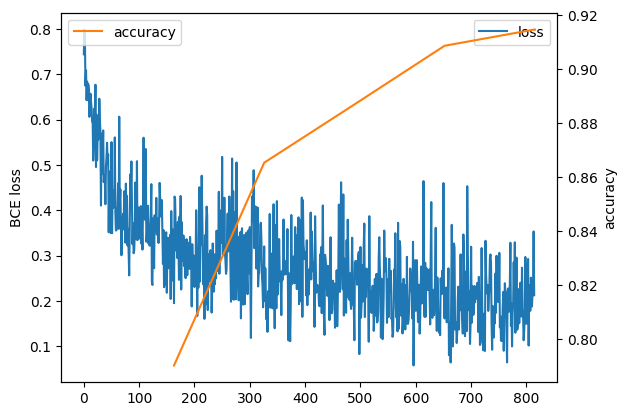

In [50]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

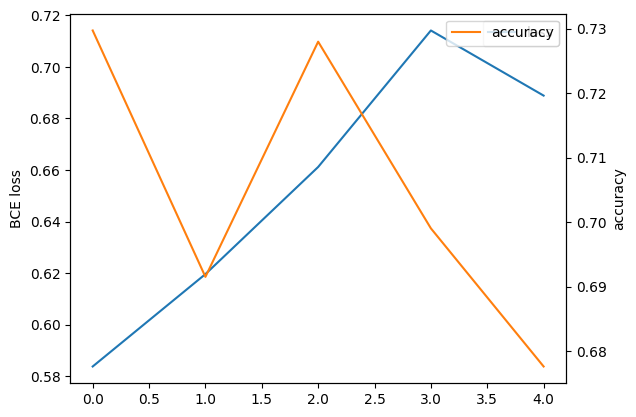

In [51]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()